# Demonstration: VQE algorithm for excited states

In [1]:
import pennylane as qml
from pennylane import numpy as np
import jax
import jax.numpy as jnp
from jax import jit
from functools import partial

from matplotlib import pyplot as plt

import copy
import tqdm  # Pretty progress bars
import joblib  # Writing and loading

import sys
sys.path.insert(0, '../')
import vqe
import ising_chain
import annni_model
import hamiltonians
import visualization as qplt
import losses
##############


In [2]:
myvqe = vqe.load_vqe('../data/vqes/ANNNI/N8n30')

In [3]:
# Train VQE for Ground States
myvqe.train_excited(.3, 500, 5)
myvqe.train_refine_excited(.25, 5000, 0.01, 5, assist = True)
myvqe.train_refine_excited(.1, 3000, 0.01, 5, assist = True)

  0%|          | 0/900 [00:00<?, ?it/s]

  0%|          | 0/900 [00:00<?, ?it/s]

  0%|          | 0/900 [00:00<?, ?it/s]

In [66]:
myvqe.train_refine_excited(.25, 500, 0.003, 3, assist = True)

  0%|          | 0/900 [00:00<?, ?it/s]

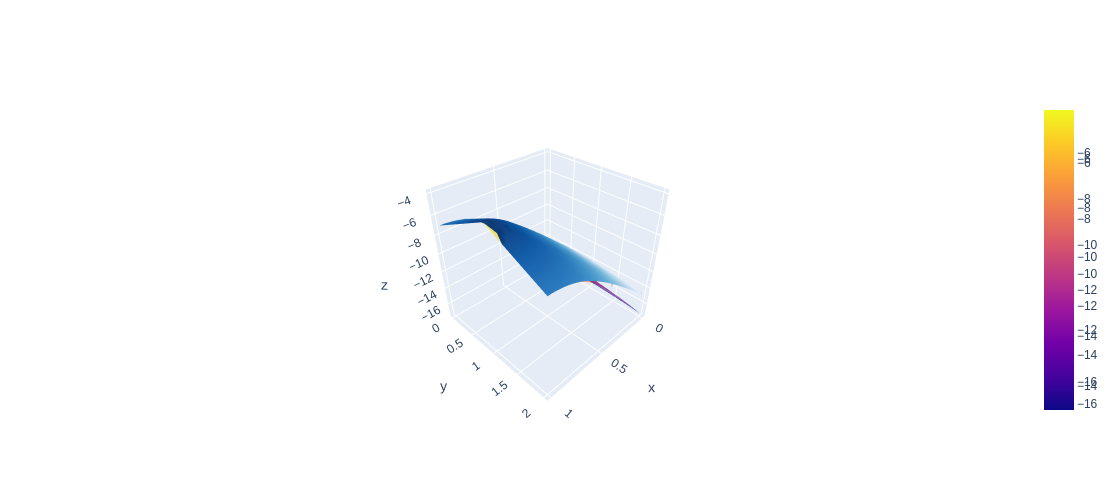

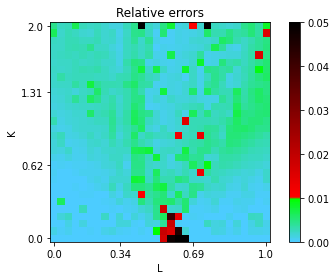

In [67]:
qplt.show_VQE_annni(myvqe, log_heatmap = False, excited = True)

In [32]:
side = 30

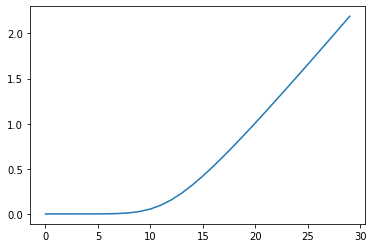

In [38]:
column = 0
idxs = np.arange((column)*side, (column+1)*side)

plt.plot(myvqe.true_e1[idxs] - myvqe.true_e0[idxs])

In [40]:
def function(x, row):
    return myvqe.true_e1[row + x*side] - myvqe.true_e0[row + x*side]

In [44]:
import general as qmlgen

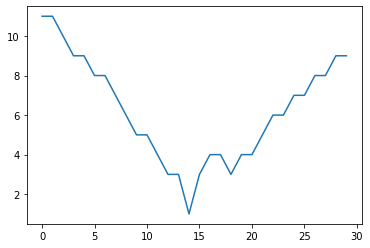

In [63]:
plt.plot(kinks)

12

In [119]:
j2j1 = np.unique(myvqe.Hs.model_params[:,2])
j2j1

tensor([-1.        , -0.96551724, -0.93103448, -0.89655172, -0.86206897,
        -0.82758621, -0.79310345, -0.75862069, -0.72413793, -0.68965517,
        -0.65517241, -0.62068966, -0.5862069 , -0.55172414, -0.51724138,
        -0.48275862, -0.44827586, -0.4137931 , -0.37931034, -0.34482759,
        -0.31034483, -0.27586207, -0.24137931, -0.20689655, -0.17241379,
        -0.13793103, -0.10344828, -0.06896552, -0.03448276,  0.        ], requires_grad=True)

In [23]:
j2j1[20]


tensor(-0.31034483, requires_grad=True)

In [24]:
idxs = np.arange(900)[myvqe.Hs.model_params[:,2] == j2j1[20]]

delta_es = (myvqe.true_e1[idxs] - myvqe.true_e0[idxs])/myvqe.Hs.N
delta_es2 = (myvqe2.true_e1[idxs] - myvqe2.true_e0[idxs])/myvqe2.Hs.N

NameError: name 'myvqe' is not defined

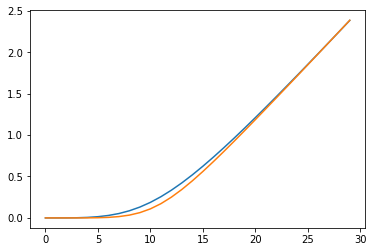

In [25]:
plt.plot(delta_es)
plt.plot(delta_es2)

In [80]:
myvqe.save('../data/vqes/ANNNI/N12n30')

In [86]:
myvqe2 = load_vqe('../data/vqes/ANNNI/N8n30')

In [77]:
myvqe = vqe.load_vqe('../data/vqes/ANNNI/N12n30')

In [78]:
myvqe.train_excited(.3, 0, 5)

  0%|          | 0/900 [00:00<?, ?it/s]

In [ ]:
kinks = []
for k in range(side):
    x = np.arange(side)
    #f_vqe = myvqe.vqe_e1[side*k + x] - myvqe.vqe_e0[side*k + x]
    f_true = myvqe.true_e1[side*k + x] - myvqe.true_e0[side*k + x]
    plt.plot(f_vqe)
    plt.plot(f_true)
    plt.axvline(x = qmlgen.find_kink(f_true, np.arange(side))[0], color = 'red', alpha = .3)
    kinks.append( qmlgen.find_kink(f_true, np.arange(side))[1] )
    plt.show()
    
plt.plot(kinks)
plt.show()

In [87]:
vqe1 = vqe.load_vqe('../data/vqes/ANNNI/N8n30')
vqe2 = vqe.load_vqe('../data/vqes/ANNNI/N12n30')

In [42]:
j2j1 = np.unique(vqe1.Hs.model_params[:,2])
idxs = np.arange(900)[vqe1.Hs.model_params[:,2] == j2j1[20]]

delta_es = (vqe1.true_e1[idxs] - vqe1.true_e0[idxs])*vqe1.Hs.N
delta_es2 = (vqe2.true_e1[idxs] - vqe2.true_e0[idxs])*vqe2.Hs.N

(0.0, 5.0)

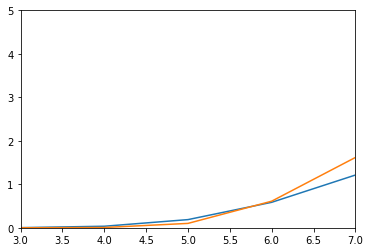

In [49]:
plt.plot(delta_es)
plt.plot(delta_es2)

plt.xlim(3,7)
plt.ylim(0,5)

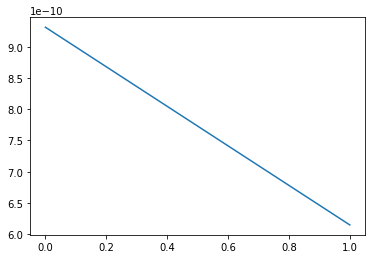

In [54]:
plt.plot(np.square(delta_es -delta_es2)[:2])

In [127]:
def findC(*vqes, info = True, plot = True):
    def find_cross(vqe1, vqe2, idxs):
        delta_e1 = (vqe1.true_e1[idxs] - vqe1.true_e0[idxs])*vqe1.Hs.N 
        delta_e2 = (vqe2.true_e1[idxs] - vqe2.true_e0[idxs])*vqe2.Hs.N 
        
        dist = delta_e1 - delta_e2
        
        signchanges = (np.diff(np.sign(dist)) != 0)*1
        return np.where(signchanges == 1)[0]
        
    n_states = [vqe.Hs.n_states for vqe in vqes]
    if len(np.unique(n_states)) > 1:
        print('Invalid VQEs, different sides not supported')
    n_states = n_states[0]
    side     = int(np.sqrt(n_states))
           
    if info:
        print('Number of VQEs: {0}'.format(len(vqes)) )
        print('Spins of VQEs: ', [vqe.Hs.N for vqe in vqes] )
        print('Side of VQEs:  ', side)
        
    j2j1 = np.unique(vqes[0].Hs.model_params[:,2])
        
    for L in j2j1:
        idxs = np.arange(n_states)[vqes[0].Hs.model_params[:,2] == L]
        
        for k, vqe1 in enumerate(vqes):
            for vqe2 in vqes[k+1:]:
                find_cross(vqe1, vqe2, idxs)
        
        if plot:
            for vqe in vqes:
                delta_es = (vqe.true_e1[idxs] - vqe.true_e0[idxs])*vqe.Hs.N
                plt.plot(np.linspace(0,2,side), delta_es)
            plt.text(.1, 20, r'$J_2/\,J_1=$'+str(np.round(L,2)))
            plt.show()
            
        

Number of VQEs: 2
Spins of VQEs:  [8, 12]
Side of VQEs:   30
[2 9]


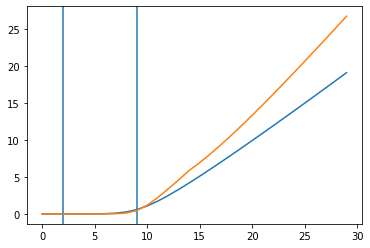

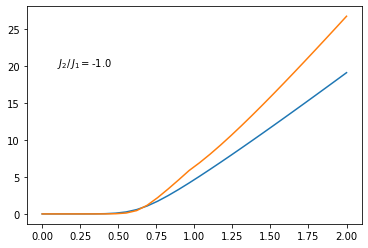

[0 1 2 9]


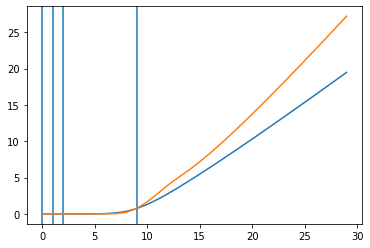

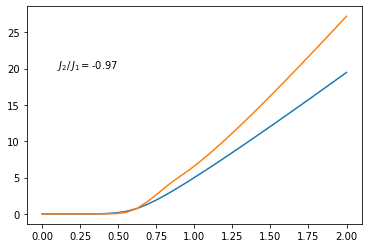

[0 2 8]


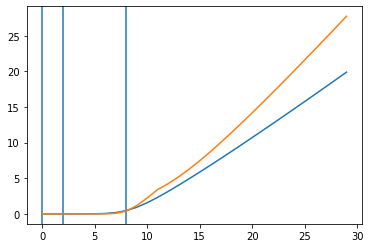

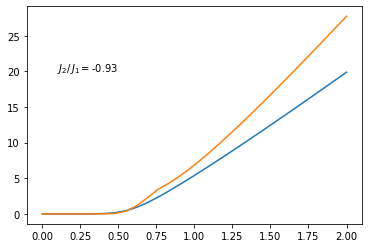

[2 7]


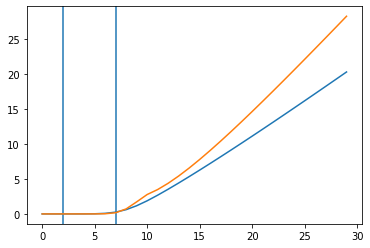

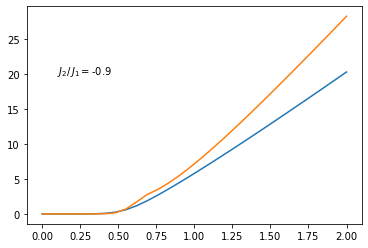

[0 2 6]


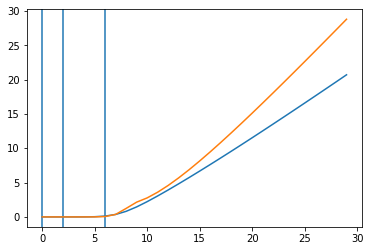

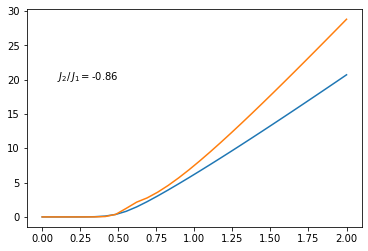

[1 6]


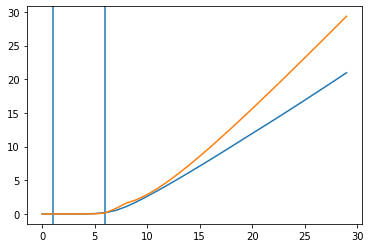

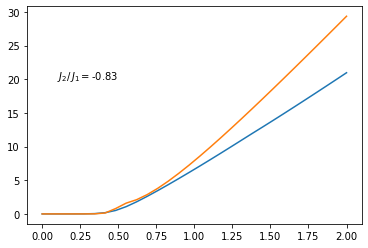

[1 5 8 9]


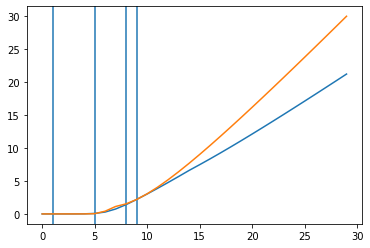

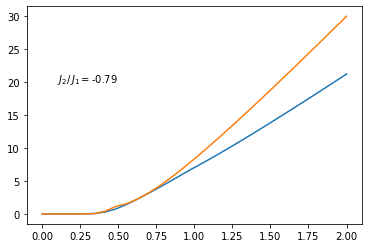

[ 1  4  6 10]


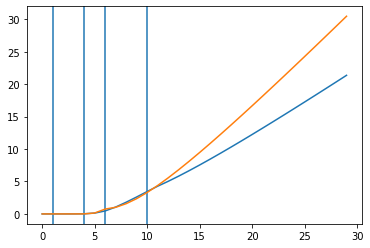

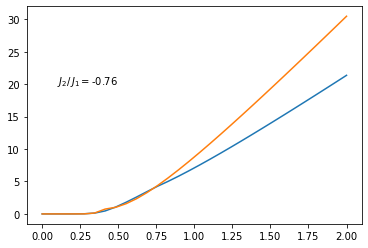

[0 4 5 9]


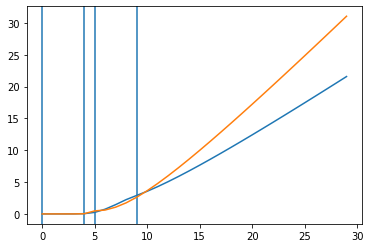

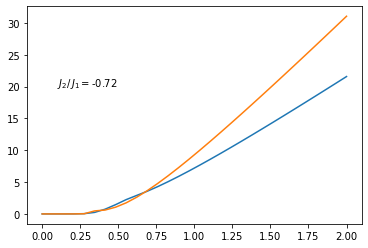

[0 3 4 8]


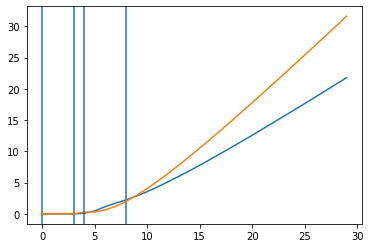

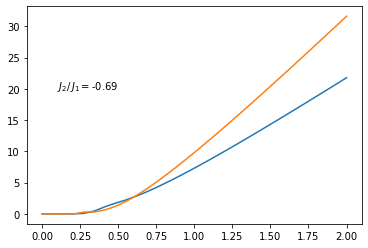

[0 1 2 3 7]


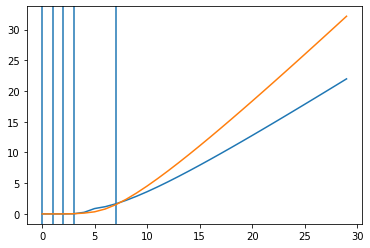

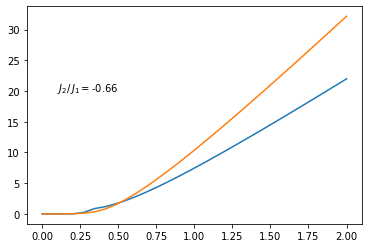

[1 6]


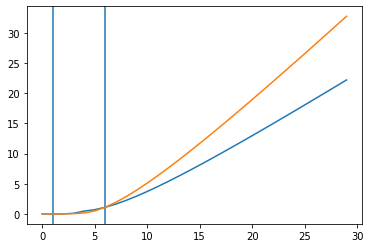

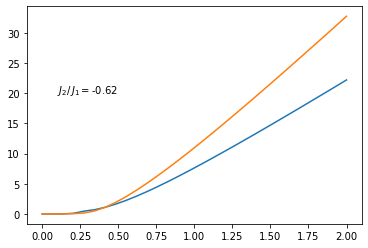

[0 4]


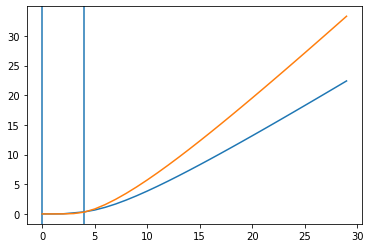

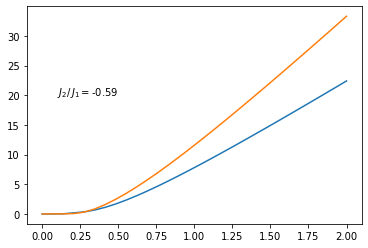

[1 2]


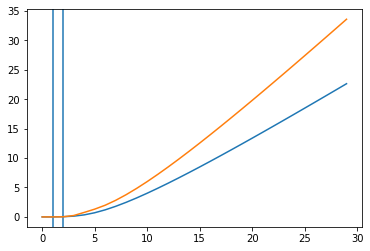

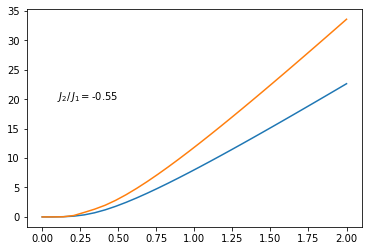

[]


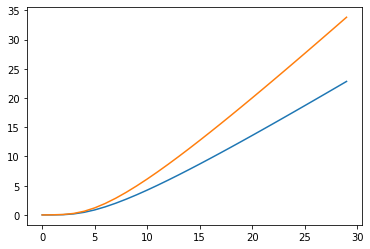

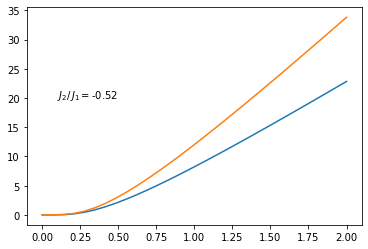

[1 3]


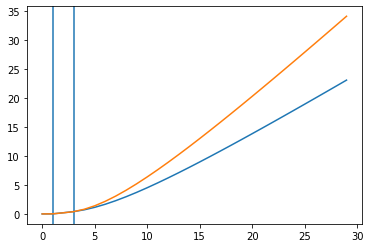

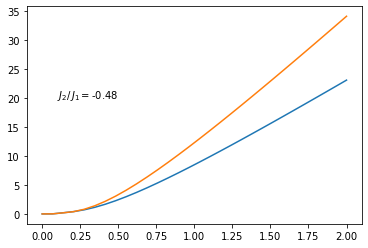

[1]


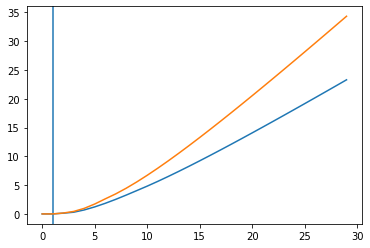

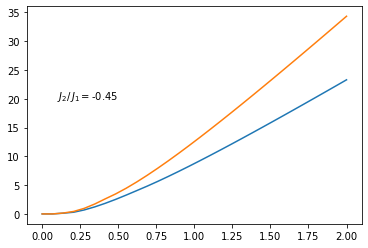

[0 1 2]


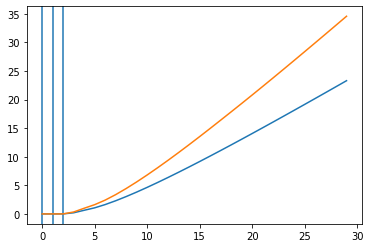

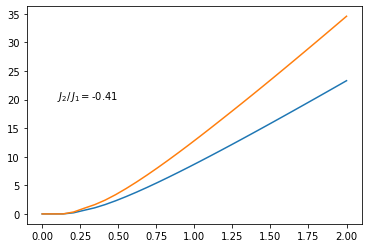

[3]


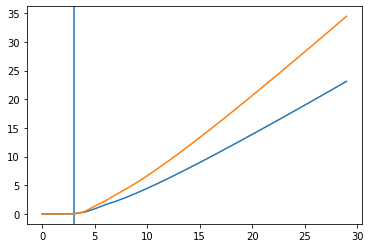

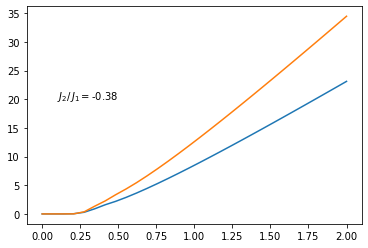

[1 4]


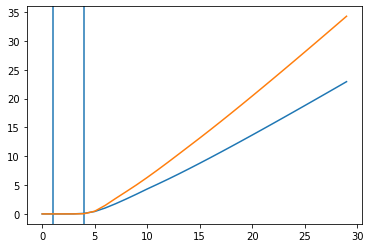

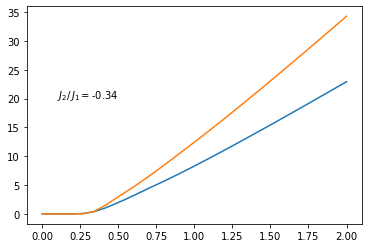

[1 5]


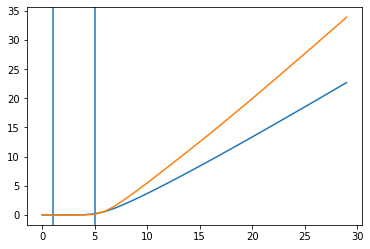

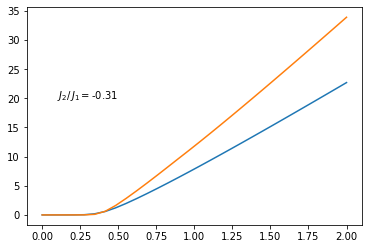

[0 6]


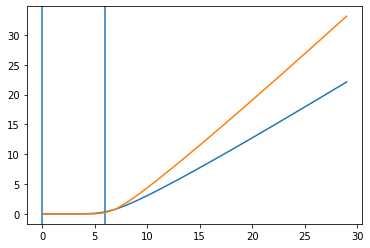

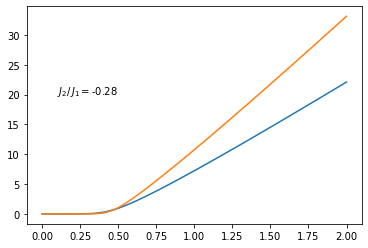

[0 7]


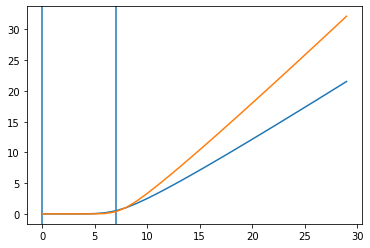

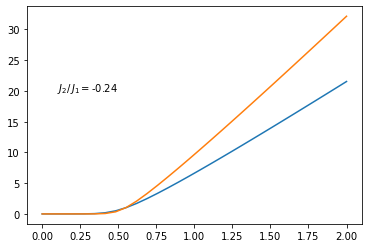

[1 8]


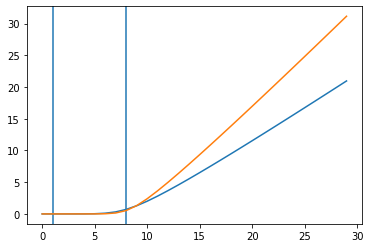

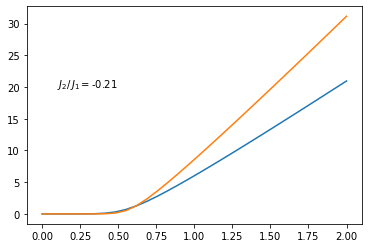

[0 9]


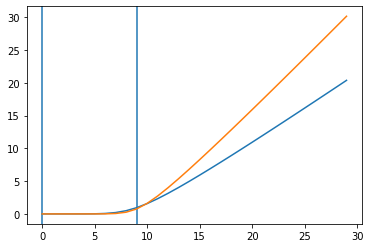

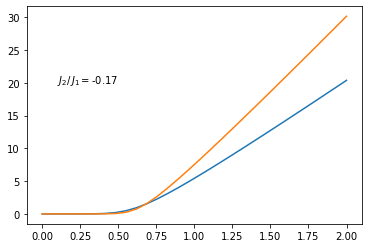

[ 0  2 10]


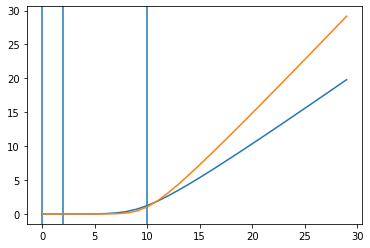

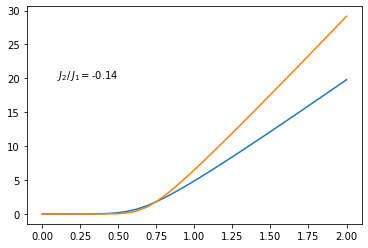

[ 0  1  2 11]


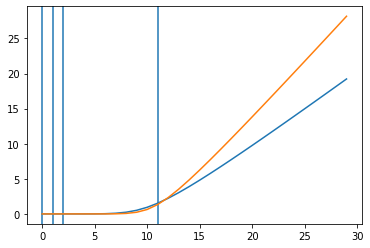

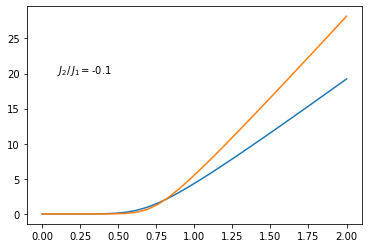

[ 1  2 12]


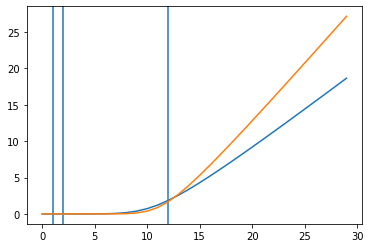

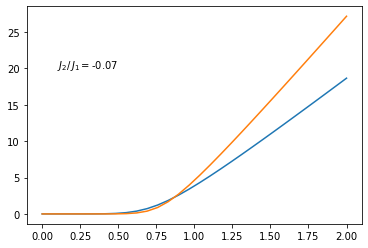

[ 3 13]


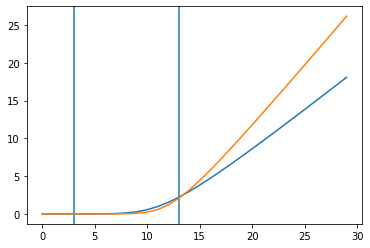

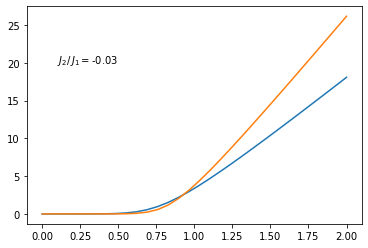

[ 0  3 14]


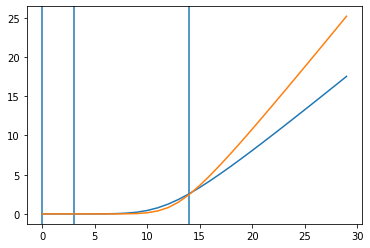

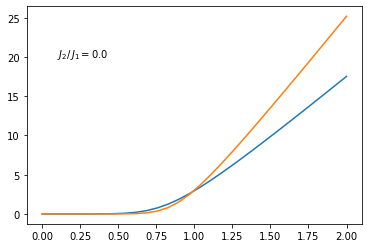

In [128]:
findC(vqe1, vqe2)

In [70]:
vqe1